# Latam challenge solution

In [68]:
import pandas as pd
import numpy as np 
import pandas_profiling as pp
from pandas_profiling import ProfileReport
from datetime import time
import matplotlib.pyplot as plt
import seaborn as sns

import eli5

import lightgbm as lgbm
import xgboost as xgb
import re

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('dataset_SCL.csv')
df_copy = df.copy()

- Fecha-I : Fecha y hora programada del vuelo.
- Vlo-I : Número de vuelo programado.
- Ori-I : Código de ciudad de origen programado. CONSTANTE
- Des-I : Código de ciudad de destino programado.
- Emp-I : Código aerolínea de vuelo programado.
- Fecha-O : Fecha y hora de operación del vuelo.
- Vlo-O : Número de vuelo de operación del vuelo.
- Ori-O : Código de ciudad de origen de operación CONSTANTE
- Des-O : Código de ciudad de destino de operación.
- Emp-O : Código aerolínea de vuelo operado.
- DIA : Día del mes de operación del vuelo.
- MES : Número de mes de operación del vuelo.
- AÑO : Año de operación del vuelo.
- DIANOM : Día de la semana de operación del vuelo.
- TIPOVUELO : Tipo de vuelo, I =Internacional, N =Nacional.
- OPERA : Nombre de aerolínea que opera.
- SIGLAORI : Nombre ciudad origen. CONSTANTE
- SIGLADES : Nombre ciudad destino.

In [3]:
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


In [5]:
df.describe()

,DIA,MES,AÑO
count,68206.000000,68206.000000,68206.000000
mean,15.714790,6.622585,2017.000029
std,8.782886,3.523321,0.005415
min,1.000000,1.000000,2017.000000
25%,8.000000,3.000000,2017.000000
50%,16.000000,7.000000,2017.000000
75%,23.000000,10.000000,2017.000000
max,31.000000,12.000000,2018.000000


Type correction 

In [6]:
df["Fecha-I"] = pd.to_datetime(df["Fecha-I"])
df["Fecha-O"] = pd.to_datetime(df["Fecha-O"])

saco valores constantes 

In [7]:
df['SIGLAORI'].unique(), df['Ori-I'].unique(), df['Ori-O'].unique()

(array(['Santiago'], dtype=object),
 array(['SCEL'], dtype=object),
 array(['SCEL'], dtype=object))

In [8]:
#valores constantes 
constantes = ['SIGLAORI', 'Ori-I', 'Ori-O']
df = df.drop(columns = constantes)

# Feature generation

In [9]:
df['temporada_alta'] = np.where(((df['Fecha-I'] >= '2016-12-15 00:00:00') & (df['Fecha-I'] < '2017-03-04 00:00:00')) | 
                                ((df['Fecha-I'] >= '2017-07-15 00:00:00') & (df['Fecha-I'] < '2017-08-01 00:00:00')) |
                                ((df['Fecha-I'] >= '2017-07-15 00:00:00') & (df['Fecha-I'] < '2017-08-01 00:00:00')) |
                                ((df['Fecha-I'] >= '2017-12-15 00:00:00') & (df['Fecha-I'] < '2018-03-04 00:00:00')),1, 0)

df['dif_min'] = df['Fecha-O'] - df['Fecha-I']
df['dif_min'] = df.dif_min.dt.total_seconds() / 60
df['atraso_15'] = df["dif_min"].apply(lambda x: 1 if int(x)> 15 else 0)

mask_1 = (df['Fecha-I'].dt.time >= time(5, 0)) & (df['Fecha-I'].dt.time <= time(11, 59))
mask_2 = (df['Fecha-I'].dt.time >= time(12, 0)) & (df['Fecha-I'].dt.time <= time(18, 59))
mask_3 = (df['Fecha-I'].dt.time >= time(19, 0)) | (df['Fecha-I'].dt.time <= time( 4, 59))
df.loc[mask_1, 'periodo_dia'] = 'mañana'
df.loc[mask_2, 'periodo_dia'] = 'tarde'
df.loc[mask_3, 'periodo_dia'] = 'noche'

In [10]:
ProfileReport(df, title='Pandas Profiling Report for training dataset', html={'style':{'full_width':True}})

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## PLanteo de hipótesis a testear 

1. ¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo?
¿Qué variables esperarías que más influyeran en predecir atrasos? 

2. ¿Deberíamos utilizar vuelos operacionales o vuelos programados?
    - Se entiende por operacional que es el vuelo real que se realizó en comparación al programado. A la hora de realizar una predicción nosotros tendriamos los datos del vuelo operacional? O es algo que se establece una vez retrasado el vuelo? 
    Podemos chequear esto viendo la diferencia de minuto para vuelos con diferentes empresas entre operacional y programado. 
    

## Preguntas 

1. ¿Por qué hay vuelos que tiene diferente número de vuelo y de operación? 
2. ¿El número de vuelo esconde algún tipo de información sobre el vuelo? 
    - Si bien es arbitrario pareciera haber prácticas comunes sobre como utilizar las cifras para designar un vuelo : 
        - https://aeronauticapy.com/2020/06/20/como-se-define-un-numero-de-vuelo/
        - https://es.wikipedia.org/wiki/N%C3%BAmero_de_vuelo

    - Pero como pareciera estar asociado a la dirección del vuelo y ya tenemos ciudad de origen y destino. Podemos en principio obviarlo y realizar un análisis posterior. 

    

    


Los id de los vuelos son únicos? Los vuelos tienen siempre el mismo código para la misma hora y el mismo día de salida. 

Los vuelos operacionales y los programados estan altamente correlacionados ya que en gran medida son los mismos. Por ende vamos a chequear si hay muchas diferencias y si no nos quedamos con una de los dos casos.

In [11]:
df[df['Vlo-I'] != df['Vlo-O']].shape

(1850, 19)

In [12]:
df = df.drop(columns = ['Vlo-O'])

En este caso hay alta correlación entre ambos. Vamos a selecionar uno solo

In [13]:
df[df['Emp-I'] != df['Emp-O']].shape

(18669, 18)

El porcentaje de diferencia entre empresa operacional y empresa programada es significativo. Por ende podemos agregar una variable que represente el hecho de que estas asignaciones sean diferentes 

In [14]:
df[df['Des-I'] != df['Des-O']].shape

(28, 18)

In [15]:
df  = df.drop(columns = ['Des-O'])

En este caso también descartamos una de las columnas 

In [16]:
df['emp_dif'] = df['Emp-I'] != df['Emp-O']
df['emp_dif'] = df['emp_dif'].apply(lambda x: int(x))

In [18]:
#sacamos emp-o porque representa la aerolinea que ya lo tenemos también en OPERA
df = df.drop(columns=['OPERA', 'Emp-O']) #opera es lo mismo que emp 0

In [19]:
df.columns 

Index(['Fecha-I', 'Vlo-I', 'Des-I', 'Emp-I', 'Fecha-O', 'DIA', 'MES', 'AÑO',
       'DIANOM', 'TIPOVUELO', 'SIGLADES', 'temporada_alta', 'dif_min',
       'atraso_15', 'periodo_dia', 'emp_dif'],
      dtype='object')

In [21]:
df[['SIGLADES', 'Des-I']][0:50]

,SIGLADES,Des-I
0,Miami,KMIA
1,Miami,KMIA
2,Miami,KMIA
3,Miami,KMIA
4,Miami,KMIA
5,Miami,KMIA
6,Miami,KMIA
7,Miami,KMIA
8,Miami,KMIA
9,Miami,KMIA


In [22]:
drop_columns = ['Fecha-O', 'Fecha-I', 'SIGLADES']
df = df.drop(columns=drop_columns)

## feature engineering 

variables posibles a agregar: 
- distancia 
- tipo de avion 
- costo de vuelo 
- horas de viaje 
- cantidad de pasajeros 
- precio de los pasajes 



## Distribución de datos

In [23]:
import numpy as np
import pandas as pd
import pandas_bokeh
pandas_bokeh.output_notebook()
pd.set_option('plotting.backend', 'pandas_bokeh')
# Create Bokeh-Table with DataFrame:
from bokeh.models.widgets import DataTable, TableColumn
from bokeh.models import ColumnDataSource

Loading BokehJS ...

In [24]:
df['DIA'].plot_bokeh(kind="hist",title ="Distribución de vuelos",
                   figsize =(900,700),
                   xlabel = "Date",
                   ylabel="vuelos"
                )

Figure(id='1003', ...)

In [25]:
df['MES'].plot_bokeh(kind="hist",title ="Distribución de vuelos",
                   figsize =(900,700),
                   xlabel = "Date",
                   ylabel="vuelos"
                )

Figure(id='1116', ...)

In [26]:
df['DIANOM'].value_counts().plot_bokeh(kind="bar",title ="Distribución de vuelos",
                   figsize =(1000,800),
                   xlabel = "Date",
                   ylabel="vuelos"
                )

Figure(id='1274', ...)

In [27]:
df['Des-I'].value_counts().plot_bokeh(kind="bar",title ="Distribución de vuelos",
                   figsize =(1000,800),
                   xlabel = "Destinos",
                   ylabel="vuelos",
                   vertical_xlabel=True)

Figure(id='1436', ...)

In [28]:
df['Emp-I'].value_counts().plot_bokeh(kind="bar",title ="Distribución de vuelos",
                   figsize =(1000,800),
                   xlabel = "Destinos",
                   ylabel="vuelos")

KeyError: 'OPERA'

In [29]:
df['periodo_dia'].value_counts().plot_bokeh(kind="bar",title ="Distribución de vuelos",
                   figsize =(1000,800),
                   xlabel = "Periodo_dia",
                   ylabel="vuelos",
                   vertical_xlabel=True)

Figure(id='1606', ...)

In [30]:
df.columns 

Index(['Vlo-I', 'Des-I', 'Emp-I', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO',
       'temporada_alta', 'dif_min', 'atraso_15', 'periodo_dia', 'emp_dif'],
      dtype='object')

In [31]:
df['dif_min'].describe()

count    68206.000000
mean         9.110855
std         19.313387
min        -14.000000
25%         -1.000000
50%          4.000000
75%         12.000000
max        161.000000
Name: dif_min, dtype: float64

In [32]:
df['dif_min'].value_counts().plot_bokeh(kind="hist", title ="Distribución de tiempo de retraso",
                    bins=np.linspace(-15, 162, 70),
                   figsize =(1000,800),
                   xlabel = "dif min",
                   ylabel="vuelos")

Figure(id='1748', ...)

Vamos a chequear si los vuelos que son distintos operacionales y programados en cuanto a la empresa presentan otro tipo de distribución de retraso

In [33]:
df.columns

Index(['Vlo-I', 'Des-I', 'Emp-I', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO',
       'temporada_alta', 'dif_min', 'atraso_15', 'periodo_dia', 'emp_dif'],
      dtype='object')

In [37]:
df.loc[df['emp_dif'] == 1, 'dif_min'].value_counts().plot_bokeh(kind="hist", title ="Distribución de tiempo de retraso",
                    bins=np.linspace(-15, 162, 70),
                   figsize =(1000,800),
                   xlabel = "dif min",
                   ylabel="vuelos")

Figure(id='1903', ...)

misma distribución


## Tasa de retraso por variable 

In [43]:
df_count = df[['Des-I', 'atraso_15']].groupby(by= ['Des-I', 'atraso_15']).size().reset_index(name="count")
df_pivot = pd.pivot_table(df_count, values='count', index ='Des-I',
                    columns=['atraso_15'], aggfunc=np.sum)

In [44]:
p_bar = df_pivot.plot_bokeh.barh(
    figsize =(1000,800),
    ylabel="Destino", 
    title="Tasa de vuelos con atraso por ciudad", 
    alpha=0.6)

In [45]:
df.columns

Index(['Vlo-I', 'Des-I', 'Emp-I', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO',
       'temporada_alta', 'dif_min', 'atraso_15', 'periodo_dia', 'emp_dif'],
      dtype='object')

In [46]:
cat_variables = ['periodo_dia', 'SIGLADES', 'temporada_alta', 'TIPOVUELO', 'DIANOM', 'MES']

In [47]:
df_count = df[['periodo_dia', 'atraso_15']].groupby(by= ['periodo_dia', 'atraso_15']).size().reset_index(name="count")
df_pivot = pd.pivot_table(df_count, values='count', index ='periodo_dia',
                    columns=['atraso_15'], aggfunc=np.sum)

In [48]:
p_bar = df_pivot.plot_bokeh.barh(
    figsize =(1000,800),
    ylabel="Periodo", 
    title="Tasa de vuelos con atraso por periodo del día", 
    alpha=0.6)

In [49]:
df_count = df[['temporada_alta', 'atraso_15']].groupby(by= ['temporada_alta', 'atraso_15']).size().reset_index(name="count")
df_pivot = pd.pivot_table(df_count, values='count', index ='temporada_alta',
                    columns=['atraso_15'], aggfunc=np.sum)

In [50]:
p_bar = df_pivot.plot_bokeh.barh(
    figsize =(1000,800),
    ylabel="tipo de vuelo", 
    title="Tasa de vuelos con atraso por temporada", 
    alpha=0.6)

In [ ]:
df_count = df[['DIANOM', 'atraso_15']].groupby(by= ['DIANOM', 'atraso_15']).size().reset_index(name="count")
df_pivot = pd.pivot_table(df_count, values='count', index ='DIANOM',
                    columns=['atraso_15'], aggfunc=np.sum)

In [ ]:
p_bar = df_pivot.plot_bokeh.barh(
    figsize =(1000,800),
    ylabel="Destino", 
    title="Tasa de vuelos con atraso por ciudad", 
    alpha=0.6)

In [ ]:
df_count = df[['MES', 'atraso_15']].groupby(by= ['MES', 'atraso_15']).size().reset_index(name="count")
df_pivot = pd.pivot_table(df_count, values='count', index ='MES',
                    columns=['atraso_15'], aggfunc=np.sum)

In [ ]:
p_bar = df_pivot.plot_bokeh.barh(
    figsize =(1000,800),
    ylabel="Mes", 
    title="Tasa de vuelos con atraso por ciudad", 
    alpha=0.6)

## Feature importance 

In [51]:
# Thanks to : https://www.kaggle.com/aantonova/some-new-risk-and-clusters-features
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [53]:
df = df.drop(columns = ['Vlo-I', 'dif_min'])

In [55]:
df_y

,Des-I,Emp-I,DIA,MES,AÑO,DIANOM,TIPOVUELO,temporada_alta,periodo_dia,emp_dif
25694,SCAT,LAN,1,5,2017,Lunes,N,0,tarde,1
9100,SCAR,LAN,20,2,2017,Lunes,N,1,mañana,0
50132,LIRF,AZA,23,10,2017,Lunes,I,0,mañana,0
34962,SCCI,LAN,10,7,2017,Lunes,N,0,noche,0
11614,SPJC,LAW,1,2,2017,Miercoles,I,1,mañana,1
...,...,...,...,...,...,...,...,...,...,...
53078,SCVD,LAN,19,10,2017,Jueves,N,0,tarde,1
60405,SABE,LAN,11,11,2017,Sabado,I,0,tarde,0
38171,SCTE,LAW,6,7,2017,Jueves,N,0,mañana,1
42411,SCFA,LAN,29,8,2017,Martes,N,0,noche,1


In [57]:
from sklearn.model_selection import train_test_split

df_x, X_valod, df_y, y_valid = train_test_split(df.drop(columns = ['atraso_15']), df.atraso_15, test_size=0.1)
train, test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2)

In [58]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = train.columns.values.tolist()
for col in features:
    if train[col].dtype in numerics: continue
    categorical_columns.append(col)
for col in categorical_columns:
    if col in train.columns:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values)) 

In [59]:
train = reduce_mem_usage(train)

Mem. usage decreased to  0.89 Mb (78.4% reduction)


In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49108 entries, 24415 to 4431
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Des-I           49108 non-null  int8 
 1   Emp-I           49108 non-null  int8 
 2   DIA             49108 non-null  int8 
 3   MES             49108 non-null  int8 
 4   AÑO             49108 non-null  int16
 5   DIANOM          49108 non-null  int8 
 6   TIPOVUELO       49108 non-null  int8 
 7   temporada_alta  49108 non-null  int8 
 8   periodo_dia     49108 non-null  int8 
 9   emp_dif         49108 non-null  int8 
dtypes: int16(1), int8(9)
memory usage: 911.2 KB


In [61]:
test = reduce_mem_usage(test)

Mem. usage decreased to  0.22 Mb (78.4% reduction)


In [62]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12277 entries, 60155 to 67200
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Des-I           12277 non-null  int8 
 1   Emp-I           12277 non-null  int8 
 2   DIA             12277 non-null  int8 
 3   MES             12277 non-null  int8 
 4   AÑO             12277 non-null  int16
 5   DIANOM          12277 non-null  int8 
 6   TIPOVUELO       12277 non-null  int8 
 7   temporada_alta  12277 non-null  int8 
 8   periodo_dia     12277 non-null  int8 
 9   emp_dif         12277 non-null  int8 
dtypes: int16(1), int8(9)
memory usage: 227.8 KB


In [65]:
train_set = lgbm.Dataset(train, y_train, silent=False)
valid_set = lgbm.Dataset(test, y_test, silent=False)

In [69]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,        
    }

modelL = lgbm.train(params, train_set = train_set, num_boost_round=1000,
                   early_stopping_rounds=50, verbose_eval=10, valid_sets=valid_set)

[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 144
[LightGBM] [Info] Number of data points in the train set: 49108, number of used features: 9
[LightGBM] [Info] Start training from score 0.184430
Training until validation sc

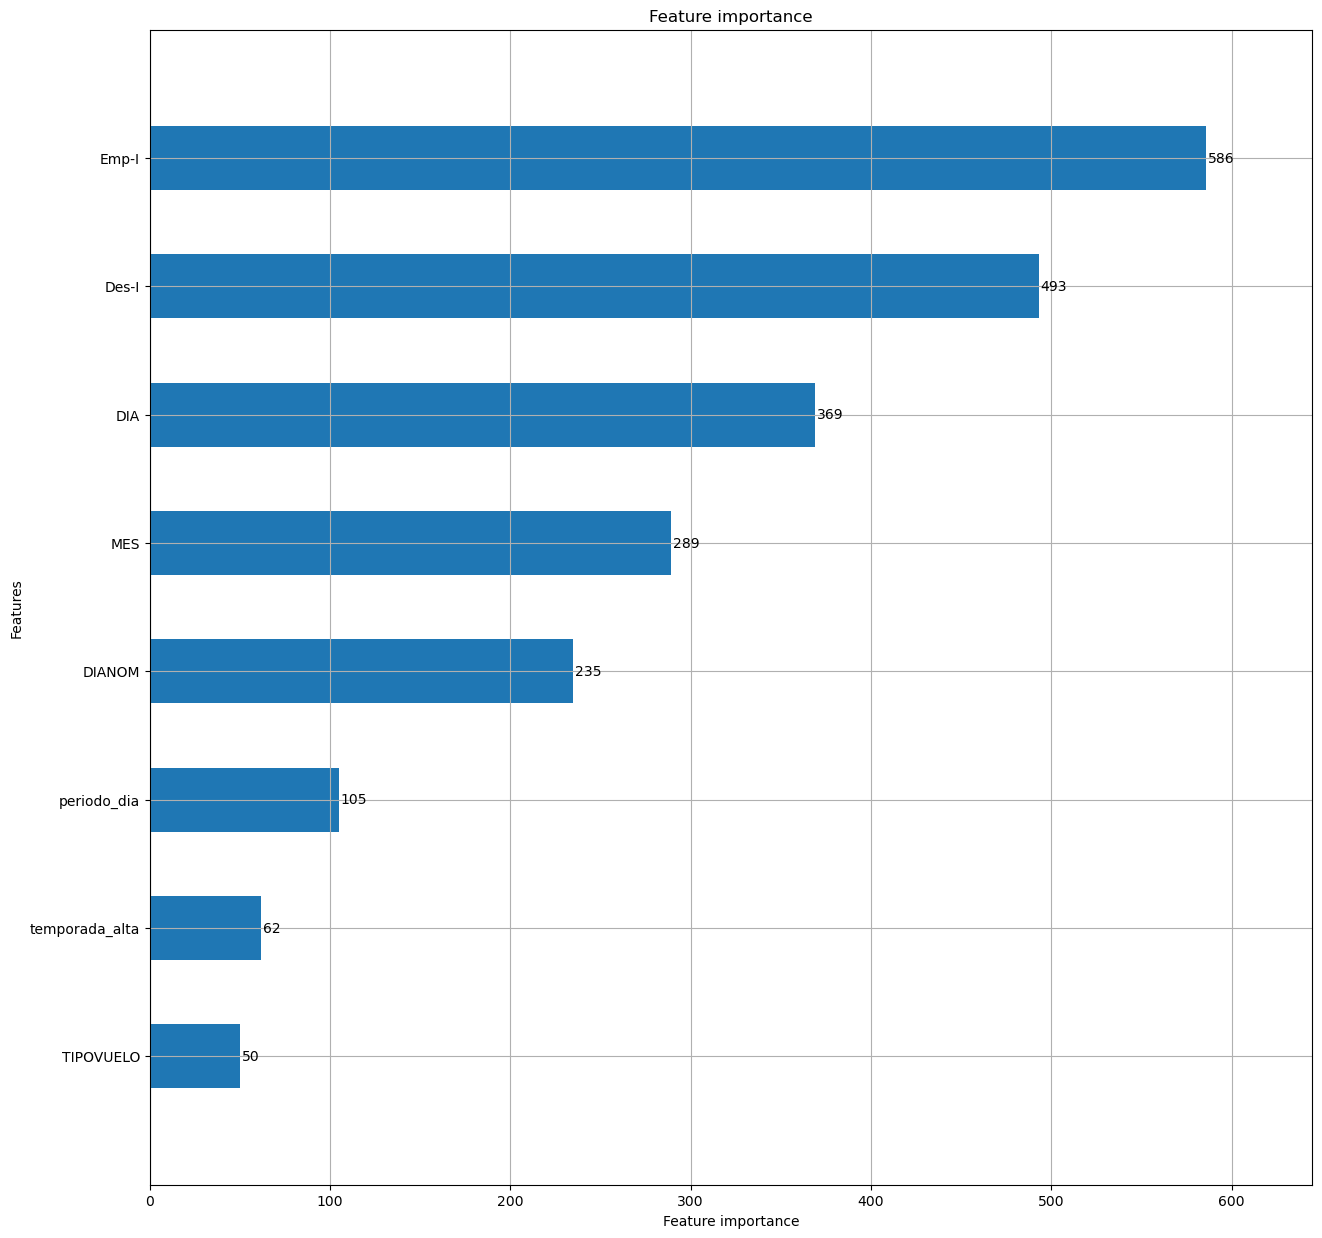

In [70]:
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
lgbm.plot_importance(modelL,ax = axes,height = 0.5)
plt.show();plt.close()

In [71]:
feature_score = pd.DataFrame(train.columns, columns = ['feature']) 
feature_score['score_lgb'] = modelL.feature_importance()

In [73]:
# Prediction
y_train_lgb = modelL.predict(train, num_iteration=modelL.best_iteration).astype('int')
y_preds_lgb = modelL.predict(test, num_iteration=modelL.best_iteration)

### XGB


In [74]:
#%% split training set to validation set 
data_tr  = xgb.DMatrix(train, label=y_train)
data_cv  = xgb.DMatrix(test   , label=y_test)
data_train = xgb.DMatrix(train)
data_test  = xgb.DMatrix(test)
evallist = [(data_tr, 'train'), (data_cv, 'valid')]

In [77]:
parms = {'max_depth':8, #maximum depth of a tree
         'objective':'reg:logistic',
         'eta'      :0.3,
         'subsample':0.8,#SGD will use this percentage of data
         #'lambda '  :4, #L2 regularization term,>1 more conservative 
         #'colsample_bytree ':0.9,
         'colsample_bylevel':1,
         'min_child_weight': 10}
modelx = xgb.train(parms, data_tr, num_boost_round=200, evals = evallist,
                  early_stopping_rounds=30, maximize=False, 
                  verbose_eval=10)

print('score = %1.5f, n_boost_round =%d.'%(modelx.best_score,modelx.best_iteration))

[0]	train-rmse:0.43981	valid-rmse:0.44052
[10]	train-rmse:0.35930	valid-rmse:0.36527
[20]	train-rmse:0.35175	valid-rmse:0.36275
[30]	train-rmse:0.34697	valid-rmse:0.36195
[40]	train-rmse:0.34372	valid-rmse:0.36118
[50]	train-rmse:0.34043	valid-rmse:0.36136
[60]	train-rmse:0.33786	valid-rmse:0.36179
[70]	train-rmse:0.33519	valid-rmse:0.36181
[78]	train-rmse:0.33329	valid-rmse:0.36233
score = 0.36111, n_boost_round =48.


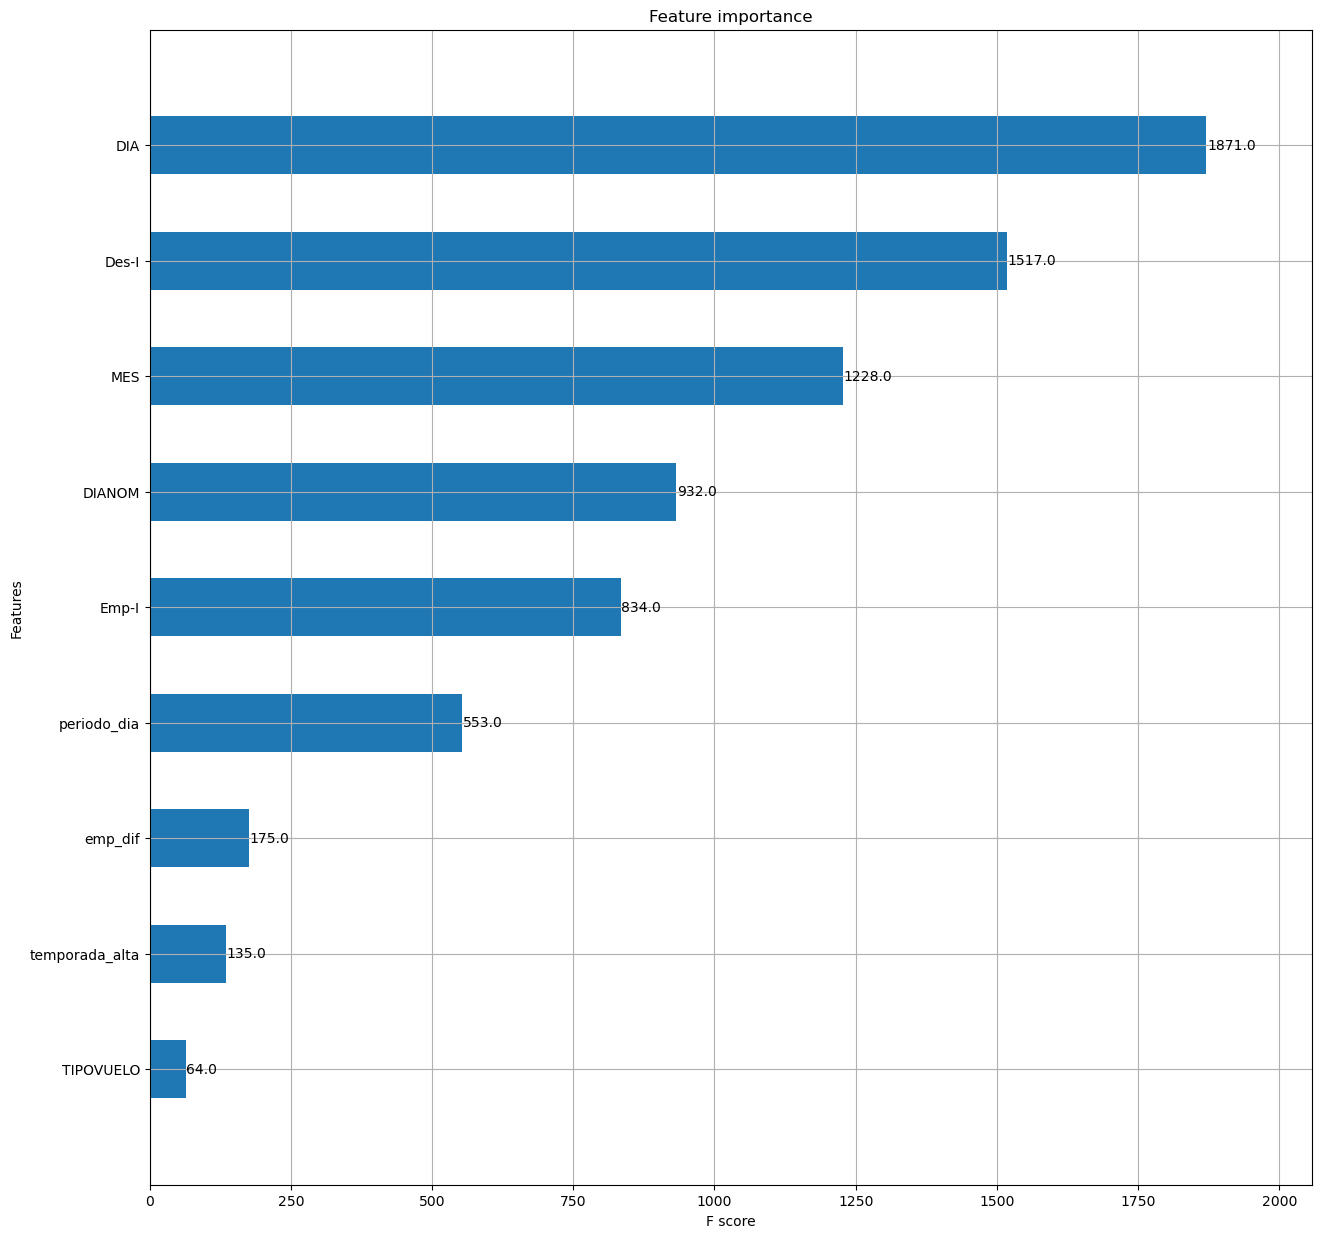

In [78]:
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
xgb.plot_importance(modelx,ax = axes,height = 0.5)
plt.show();plt.close()

In [79]:
feature_score['score_xgb'] = feature_score['feature'].map(modelx.get_score(importance_type='weight'))
feature_score

,feature,score_lgb,score_xgb
0,Des-I,493,1517.0
1,Emp-I,586,834.0
2,DIA,369,1871.0
3,MES,289,1228.0
4,AÑO,0,NaN
5,DIANOM,235,932.0
6,TIPOVUELO,50,64.0
7,temporada_alta,62,135.0
8,periodo_dia,105,553.0
9,emp_dif,0,175.0


In [80]:
# Prediction
y_train_xgb = modelx.predict(data_train).astype('int')
y_preds_xgb = modelx.predict(data_test)

In [97]:
np.unique(y_train_xgb) 

array([0])

## Logistic regresion

In [81]:
# Standardization for regression models
Scaler_train = preprocessing.MinMaxScaler()
train = pd.DataFrame(
    Scaler_train.fit_transform(train),
    columns=train.columns,
    index=train.index
)

In [82]:
test = pd.DataFrame(
    Scaler_train.fit_transform(test),
    columns=test.columns,
    index=test.index
)

In [84]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(train, y_train)
coeff_logreg = pd.DataFrame(train.columns)
coeff_logreg.columns = ['feature']
coeff_logreg["score_logreg"] = pd.Series(logreg.coef_[0])
coeff_logreg.sort_values(by='score_logreg', ascending=False)

,feature,score_logreg
3,MES,0.906043
1,Emp-I,0.461915
7,temporada_alta,0.411467
0,Des-I,0.295608
8,periodo_dia,0.240844
9,emp_dif,0.176784
5,DIANOM,0.088057
4,AÑO,-0.004300
2,DIA,-0.155788
6,TIPOVUELO,-0.652426


In [85]:
# the level of importance of features is not associated with the sign
coeff_logreg["score_logreg"] = coeff_logreg["score_logreg"].abs()
feature_score = pd.merge(feature_score, coeff_logreg, on='feature')

In [86]:
# Eli5 visualization
eli5.show_weights(logreg)

Weight?,Feature
+0.906,x3
+0.462,x1
+0.411,x7
+0.296,x0
+0.241,x8
+0.177,x9
+0.088,x5
-0.004,x4
-0.156,x2
-0.652,x6


In [87]:
# Prediction
y_train_logreg = logreg.predict(train).astype('int')
y_preds_logreg = logreg.predict(test)

Confusion Matrices

In [90]:
# Showing Confusion Matrix
# Thanks to https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud
def plot_cm(y_true, y_pred, title, figsize=(5,4)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    plt.show()

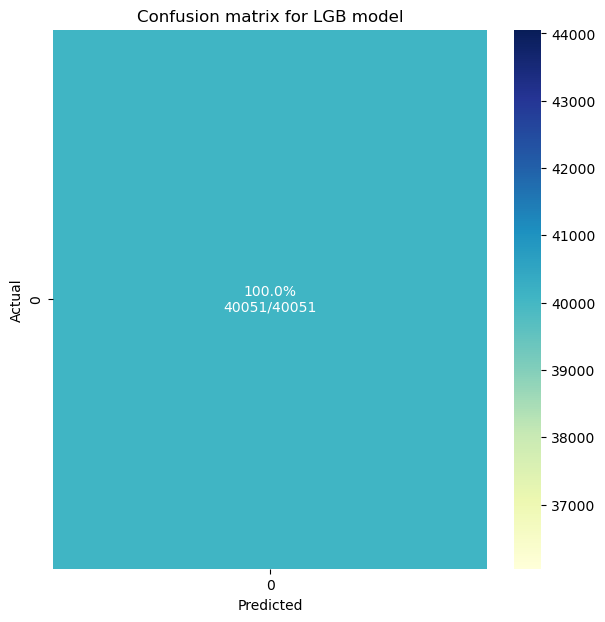

In [92]:
# Showing Confusion Matrix for LGB model
plot_cm(y_train_lgb, y_train, 'Confusion matrix for LGB model', figsize=(7,7))

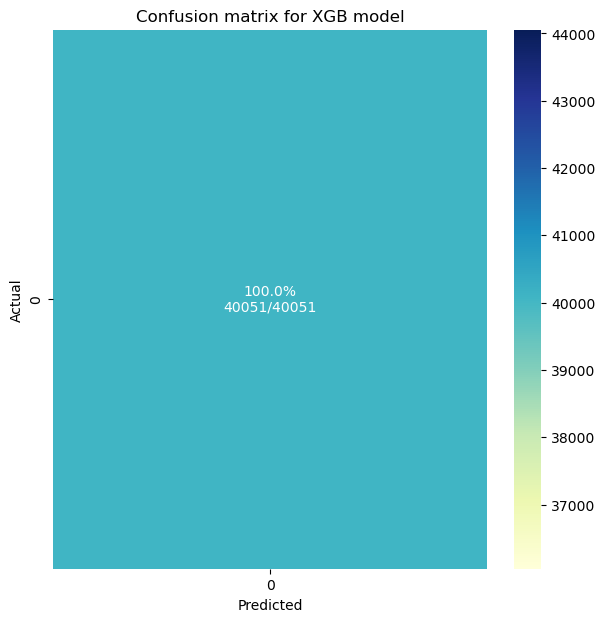

In [93]:
# Showing Confusion Matrix for XGB model
plot_cm(y_train_xgb, y_train, 'Confusion matrix for XGB model', figsize=(7,7))

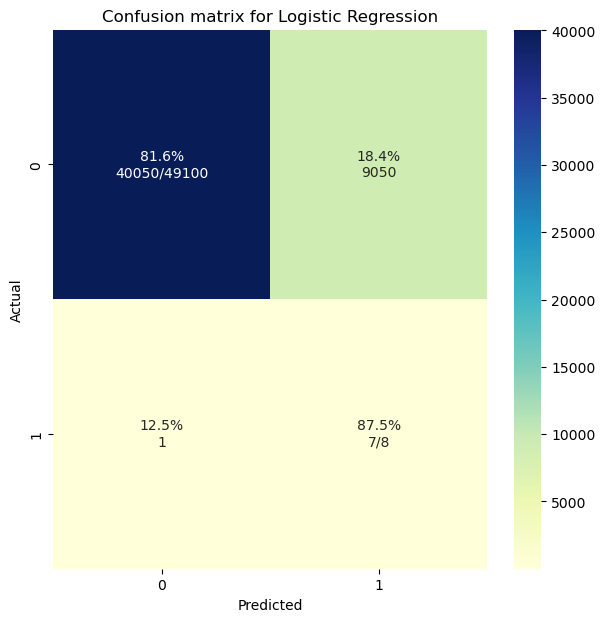

In [98]:
# Showing Confusion Matrix for Logistic Regression
plot_cm(y_train_logreg, y_train, 'Confusion matrix for Logistic Regression', figsize=(7,7))